<div style="text-align: center;">
  <h2><strong></strong></h2>
</div>

<center>

## **Prueba Técnica Novaventa**
## **Sistema de Recomendaciones: Hibrido**

**Autor:** Sebastian Carvalho Salazar  

</center>

## Librerias

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import IncrementalPCA
from scipy import sparse
import time
import numpy as np
import seaborn as sns

## Rutas

In [54]:
import yaml
import os

# Obtener la ruta absoluta del archivo paths.yaml
current_dir = current_dir = os.getcwd()
config_path = os.path.join(current_dir, '..', 'Config', 'paths.yaml')

# Cargar el contenido del archivo YAML
with open(config_path, 'r') as file:
    paths = yaml.safe_load(file)

## Datos

In [29]:
path_1 = paths['StagingZone']['dataset_1']
dataset_1 = pd.read_csv(path_1, sep=";").drop(['Unnamed: 0'], axis=1)

path_2 = paths['StagingZone']['dataset_2']
dataset_2 = pd.read_csv(path_2, sep=";").drop(['Unnamed: 0'], axis=1)

path_3 = paths['StagingZone']['productos']
productos = pd.read_csv(path_3, sep=";").drop(['Unnamed: 0'], axis=1)

path_4 = paths['TrustZone']['PCA_UBCF']
user_item_matrix_reduced = pd.read_csv(path_4, sep=";")
user_item_matrix_reduced = user_item_matrix_reduced.set_index(['UUID_CLIENTE_CONSUMIDOR'])

path_5 = paths['TrustZone']['PCA_IBCF']
item_user_matrix_reduced = pd.read_csv(path_5, sep=";")

path_6 = paths['TrustZone']['CS_IBCF']
item_similarity_matrix = pd.read_parquet(path_6)

path_7 = paths['StagingZone']['user_item_matrix']
user_item_matrix = pd.read_parquet(path_7)

## Sistema de Recomendaciones

In [30]:
%run models.ipynb

In [32]:
user_id = user_item_matrix_reduced.sample(1).index[0]

print(f"USER_ID: {user_id} \n")

top_k_users, recommended_products = recommend_products_ubcf(user_id, user_item_matrix, user_item_matrix_reduced)
top_k_items, recommendations = recommend_products_ibcf(user_id, user_item_matrix, item_similarity_matrix)

def union_recommendations(user_based_recs, item_based_recs):
    combined_recs = list(set(user_based_recs) | set(item_based_recs))
    return combined_recs

recommendations_union = union_recommendations(recommended_products, recommendations)

print(f"Productos Recomendados: \n")

productos[productos['COD_PRODUCTO'].isin(recommendations_union)].reset_index(drop=True)

USER_ID: 7E9DB0C7CD200125680A180326615250 

Productos Recomendados: 



,COD_PRODUCTO,CATEGORIA
0,2,Galletas
1,65,Golosinas
2,19,Galletas
3,307,Alimentos Larga Vida Y Conservas
4,24,Golosinas
5,10,Galletas


In [33]:
dataset_2[dataset_2['UUID_CLIENTE_CONSUMIDOR']==user_id]

,UUID_CLIENTE_CONSUMIDOR,DEPARTAMENTO,CIUDAD,GENERO_DIM_CLIENTE,FECHANACIMIENTO_DIM_CLIENTE,EDAD
73602,7E9DB0C7CD200125680A180326615250,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",F,1987-09-09,36.0
130436,7E9DB0C7CD200125680A180326615250,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",F,1987-09-09,36.0
173143,7E9DB0C7CD200125680A180326615250,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",F,1987-09-09,36.0


## Rendimiento

In [11]:
def measure_execution_time():
    start_time = time.time()
    
    user_id = user_item_matrix_reduced.sample(1).index[0]
    top_k_users, recommended_products = recommend_products_ubcf(user_id, user_item_matrix, user_item_matrix_reduced)
    top_k_items, recommendations = recommend_products_ibcf(user_id, user_item_matrix, item_similarity_matrix)
    recommendations_union = union_recommendations(recommended_products, recommendations)
    
    end_time = time.time()
    return end_time - start_time

execution_times = []

for _ in range(100):
    execution_time = measure_execution_time()
    execution_times.append(execution_time)

average_time = np.mean(execution_times)
std_time = np.std(execution_times)

print(f"Average execution time over 100 runs: {average_time} ± {std_time} seconds")

Average execution time over 100 runs: 3.337586762905121 ± 1.630285665153035 seconds


## Pruebas A/B

In [95]:
# Seleccionar una muestra aleatoria de usuarios
users = dataset_1['UUID_CLIENTE_CONSUMIDOR'].drop_duplicates()
sample_users = pd.DataFrame(users.sample(frac=0.01, random_state=42))  # 1% de los usuarios

# Asignar aleatoriamente a los usuarios a los grupos A y B
sample_users['group'] = np.random.choice(['A', 'B'], size=len(sample_users))

def recommend_system_A(user_id):
    _ , recommended_products = recommend_products_ubcf(user_id, user_item_matrix, user_item_matrix_reduced)
    return recommended_products
    

def recommend_system_B(user_id):
    _ , recommendations = recommend_products_ibcf(user_id, user_item_matrix, item_similarity_matrix)
    return recommendations

sample_users['recommendations'] = sample_users.apply(
    lambda row: recommend_system_A(row['UUID_CLIENTE_CONSUMIDOR']) if row['group'] == 'A' else recommend_system_B(row['UUID_CLIENTE_CONSUMIDOR']),
    axis=1
)

# Calcular la métrica de desempeño
def calculate_performance_metric(recommendations):
    # Filtrar el DataFrame de productos para obtener solo los recomendados
    recommended_products_df = dataset_1[dataset_1['COD_PRODUCTO'].isin(recommendations)]
    # Sumar el valor de 'VENTA_BRUTA_CON_IVA' para los productos recomendados
    total_value = recommended_products_df['VENTA_BRUTA_CON_IVA'].sum()
    return total_value

sample_users['performance_metric'] = sample_users['recommendations'].apply(calculate_performance_metric)

# Calcular la métrica promedio para cada grupo
group_performance = sample_users.groupby('group')['performance_metric'].mean()

if group_performance['B'] > group_performance['A']:
    print('El sistema de recomendación B es mejor. Considere implementarlo.')
else:
    print('El sistema de recomendación A es mejor o no hay diferencias significativas.')

group_performance = pd.DataFrame(group_performance)

sample_users.to_csv(paths['Test']['AB_TEST_DETAIL'], sep=";", index=False)
group_performance.to_csv(paths['Test']['AB_TEST_RESUM'], sep=";")

pd.set_option('display.float_format', lambda x: '%.0f' % x)
group_performance

In [ ]:
print(f"B - A = {np.round(group_performance.iloc[1] - group_performance.iloc[0],0)[0]}$")

B - A = 2586555.0$


In [109]:
# Definir una función para eliminar outliers utilizando el rango intercuartil
def eliminar_outliers_iqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[columna] >= lower_bound) & (df[columna] <= upper_bound)]

sample_users = pd.read_csv(paths['Test']['AB_TEST_DETAIL'], sep=";")

# Aplicar la función para eliminar outliers en la columna 'EDAD'
dataset_a_sin_outliers = eliminar_outliers_iqr(sample_users[sample_users['group']=='A'], 'performance_metric')
dataset_b_sin_outliers = eliminar_outliers_iqr(sample_users[sample_users['group']=='B'], 'performance_metric')
# Unir los datasets de nuevo
dataset_unido_sin_outliers = pd.concat([dataset_a_sin_outliers, dataset_b_sin_outliers])

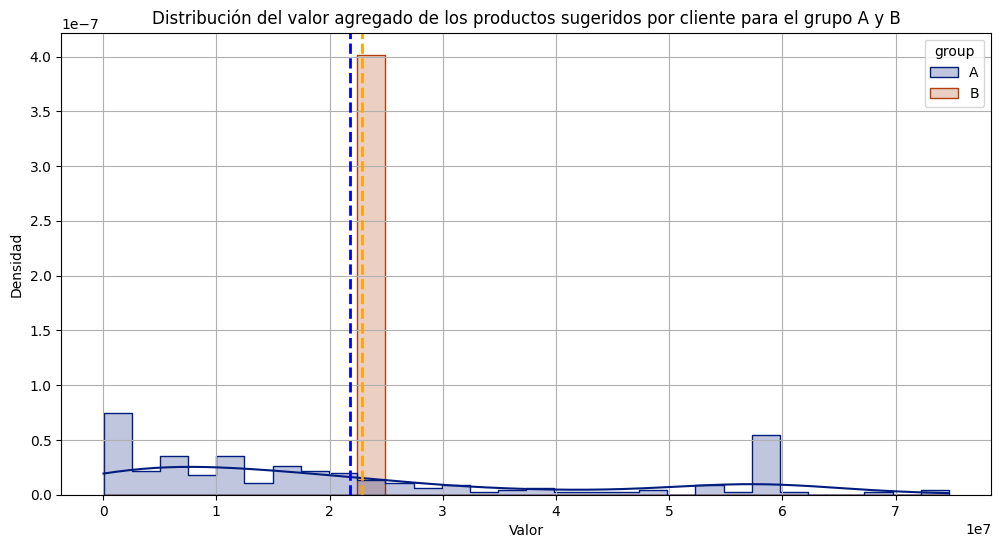

Estadístico de Wilcoxon: 5541.0
Valor p: 0.012516080305270464
Hay evidencia suficiente para rechazar la hipótesis nula: El valor del grupo B es significativamente mayor que el del grupo A.


In [119]:
from scipy.stats import wilcoxon

metrica_a = dataset_a_sin_outliers['performance_metric'].values
metrica_b = dataset_b_sin_outliers['performance_metric'].values

# Calcular los prmedios
mean_a = np.mean(metrica_a)
mean_b = np.mean(metrica_b)

if len(metrica_a) > len(metrica_b):
    metrica_a = metrica_a[:len(metrica_b)]
else:
    metrica_b = metrica_b[:len(metrica_a)]

# Distribución de la edad por género sin outliers
plt.figure(figsize=(12, 6))
sns.histplot(data=dataset_unido_sin_outliers, x='performance_metric', hue='group', kde=True, element='step', stat='density', common_norm=False, palette='dark')
plt.axvline(mean_a, color='blue', linestyle='dashed', linewidth=1, label=f'Mediana Hombres: {mean_a:.2f}',lw=2)
plt.axvline(mean_b, color='orange', linestyle='dashed', linewidth=1, label=f'Mediana Mujeres: {mean_b:.2f}', lw=2)
plt.title('Distribución del valor agregado de los productos sugeridos por cliente para el grupo A y B')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

# Aplicar la prueba de Wilcoxon para comparar las métricas
stat, p_value = wilcoxon(metrica_a, metrica_b, alternative='less')

# Mostrar resultados de la prueba de Wilcoxon
print(f'Estadístico de Wilcoxon: {stat}')
print(f'Valor p: {p_value}')

# Interpretación del valor p con un nivel de confianza del 95%
if p_value < 0.05:
    print("Hay evidencia suficiente para rechazar la hipótesis nula: El valor del grupo B es significativamente mayor que el del grupo A.")
else:
    print("No hay evidencia suficiente para rechazar la hipótesis nula: El valor del grupo B no es significativamente mayor que el del grupo A.")

En conclusión, se prefiere el modelo A debido a que genera un margen similar de ganancias al modelo B y, además, presenta mayor variabilidad en la cantidad de productos sugeridos. Esta mayor variabilidad es beneficiosa para un e-commerce porque ofrece a los clientes una experiencia de compra más dinámica y personalizada, lo cual puede aumentar la satisfacción del cliente y las probabilidades de compra repetida. Además, un rango más amplio de recomendaciones permite al negocio identificar patrones de preferencias más diversos, adaptarse mejor a diferentes segmentos de mercado y aprovechar oportunidades de ventas adicionales a través de la exposición a productos variados. Por lo tanto, el modelo A no solo mantiene un rendimiento financiero comparable al modelo B, sino que también contribuye a una estrategia de ventas más flexible y potencialmente más rentable a largo plazo. Tambien es posible obtar por una estrategia hibrida A-B.

# FIN
---